# Tensorflow 2.

## 入门

win10下安装anaconda3+python3.7+tensorflow2.0.0(GPU)+cuda10.0+cudnn+pytorch及查看cuda+cudnn版本

https://blog.csdn.net/weixin_42267309/article/details/92800901?utm_medium=distribute.pc_relevant.none-task-blog-BlogCommendFromMachineLearnPai2-4.nonecase&depth_1-utm_source=distribute.pc_relevant.none-task-blog-BlogCommendFromMachineLearnPai2-4.nonecase

In [1]:
import tensorflow as tf

tf.__version__

'2.1.0'

### 面向萌新入门

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

载入并准备好 MNIST 数据集。将样本从整数转换为浮点数：

In [3]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

11493376/11490434 [==============================] - 175s 15us/step


In [6]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

将模型的各层堆叠起来，以搭建 tf.keras.Sequential 模型。为训练选择优化器和损失函数：

In [4]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation="softmax")
])

model.compile(optimizer = "adam",
             loss = "sparse_categorical_crossentropy",
             metrics=["accuracy"])

In [5]:
model.fit(x_train, y_train, epochs=5)

model.evaluate(x_test, y_test, verbose=2)

Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - 3s 53us/sample - loss: 0.2980 - accuracy: 0.9116
Epoch 2/5
60000/60000 [==============================] - 3s 46us/sample - loss: 0.1431 - accuracy: 0.9574
Epoch 3/5
60000/60000 [==============================] - 3s 45us/sample - loss: 0.1107 - accuracy: 0.9669
Epoch 4/5
60000/60000 [==============================] - 3s 45us/sample - loss: 0.0889 - accuracy: 0.9721
Epoch 5/5
60000/60000 [==============================] - 3s 46us/sample - loss: 0.0758 - accuracy: 0.9762
10000/10000 - 0s - loss: 0.0769 - accuracy: 0.9778


[0.07691029577557928, 0.9778]

### 面向老油条入门

In [50]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model

加载并准备 MNIST 数据集。

In [51]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Add a channels dimension
x_train = x_train[..., tf.newaxis]  # 末位增加一个维度
x_test = x_test[..., tf.newaxis]

In [52]:
x_train.shape, x_test.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [53]:
# tf.newaxis 增加维度
# 三维时：[..., 1] 相当于 [:,:,1]， 二维时：[..., 1] 相当于 [:, 1]
# tf.newaxis所在位置增加一个维度
# 原数组shape [2, 3], [:, tf.newaxis] 相当于 [2, 1, 3], [tf.newaxis,:]相当于[1,2,3]

使用 tf.data 来将数据集切分为 batch 以及混淆数据集：

In [54]:
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(10000).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

In [55]:
# shuffle 参考 https://blog.csdn.net/zaf0516/article/details/100775285

使用 Keras 模型子类化（model subclassing） API 构建 tf.keras 模型：

In [62]:
class MyModel(Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = Conv2D(32, 3, activation='relu')
        self.flatten = Flatten()
        self.d1 = Dense(128, activation='relu')
        self.d2 = Dense(10, activation='softmax')

    def call(self, x):
        x = self.conv1(x)
        x = self.flatten(x)
        x = self.d1(x)
        return self.d2(x)

model = MyModel()

为训练选择优化器与损失函数：

In [63]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

选择衡量指标来度量模型的损失值（loss）和准确率（accuracy）。这些指标在 epoch 上累积值，然后打印出整体结果。

In [64]:
train_loss = tf.keras.metrics.Mean(name="train_loss")
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name="train_accuracy")

test_loss = tf.keras.metrics.Mean(name="test_loss")
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name="test_accuracy")

使用 tf.GradientTape 来训练模型：

In [66]:
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)

测试模型：

In [67]:
@tf.function
def test_step(images, labels):
    predictions = model(images)
    t_loss = loss_object(labels, predictions)

    test_loss(t_loss)
    test_accuracy(labels, predictions)

In [68]:
EPOCHS = 5

for epoch in range(EPOCHS):
    # 在下一个epoch开始时，重置评估指标
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for images, labels in train_ds:
        train_step(images, labels)

    for test_images, test_labels in test_ds:
        test_step(test_images, test_labels)

    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print (template.format(epoch+1,
                         train_loss.result(),
                         train_accuracy.result()*100,
                         test_loss.result(),
                         test_accuracy.result()*100))

W0611 03:32:43.790379  5564 base_layer.py:1790] Layer my_model_4 is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



Epoch 1, Loss: 0.13700036704540253, Accuracy: 95.8983383178711, Test Loss: 0.06450790911912918, Test Accuracy: 97.86000061035156
Epoch 2, Loss: 0.041841451078653336, Accuracy: 98.69499969482422, Test Loss: 0.054831746965646744, Test Accuracy: 98.1199951171875
Epoch 3, Loss: 0.02212349884212017, Accuracy: 99.29500579833984, Test Loss: 0.05377575755119324, Test Accuracy: 98.43000030517578
Epoch 4, Loss: 0.013619402423501015, Accuracy: 99.51499938964844, Test Loss: 0.055424876511096954, Test Accuracy: 98.29999542236328
Epoch 5, Loss: 0.009999733418226242, Accuracy: 99.65833282470703, Test Loss: 0.061392709612846375, Test Accuracy: 98.4000015258789


## Keras基础

### 基本图像分类

In [69]:
# Tensorflow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.1.0


Import the Fashion MNNIST dataset

In [71]:
fashion_mnist = keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 21s 5us/step


The images are 28x28 NumPy arrays, with pixel values ranging from 0 to 255. The labels are an array of integers, ranging from 0 to 9.

In [72]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [74]:
train_images.shape

(60000, 28, 28)

In [75]:
len(train_labels)

60000

In [76]:
test_images.shape

(10000, 28, 28)

In [77]:
len(test_labels)

10000

#### Preprocess the data

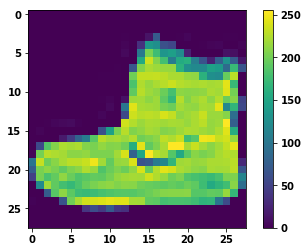

In [79]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

Scale these values to a range of 0 to 1 before feeding them to the neural network model. To do so, divide the values by 255.

In [80]:
train_images = train_images / 255.0

test_images = test_images / 255.0

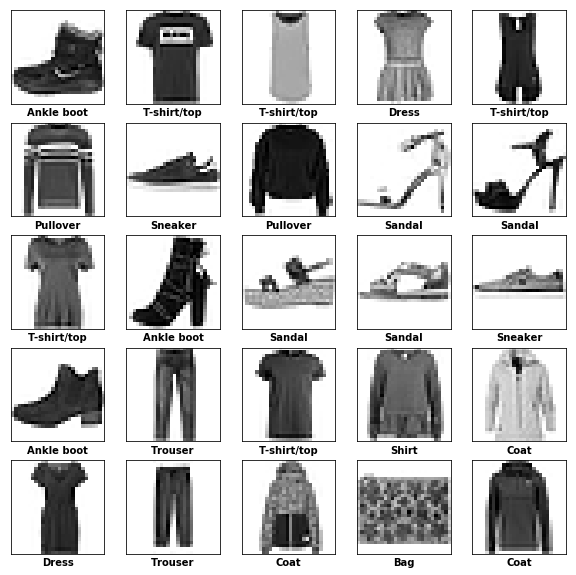

In [84]:
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

#### Build the model

In [85]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(10)
])

The first layer in this network, tf.keras.layers.Flatten, transforms the format of the images from a two-dimensional array (of 28 by 28 pixels) to a one-dimensional array (of 28 * 28 = 784 pixels). Think of this layer as unstacking rows of pixels in the image and lining them up. This layer has no parameters to learn; it only reformats the data.

After the pixels are flattened, the network consists of a sequence of two tf.keras.layers.Dense layers. These are densely connected, or fully connected, neural layers. The first Dense layer has 128 nodes (or neurons). The second (and last) layer returns a logits array with length of 10. Each node contains a score that indicates the current image belongs to one of the 10 classes.

#### Compile the model

In [86]:
# Loss function : 损失函数
# Opitmizer: 优化器
# Metrics: 评估度量

In [87]:
model.compile(optimizer="adam",
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=["accuracy"])

#### Train the model

Training the neural network model requires the following steps:

+ Feed the training data to the model. In this example, the training data is in the train_images and train_labels arrays.
+ The model learns to associate images and labels.
+ You ask the model to make predictions about a test set—in this example, the test_images array.
+ Verify that the predictions match the labels from the test_labels array.

In [88]:
model.fit(train_images, train_labels, epochs=10)

Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 3s 50us/sample - loss: 0.4936 - accuracy: 0.8263
Epoch 2/10
60000/60000 [==============================] - 3s 46us/sample - loss: 0.3762 - accuracy: 0.8632
Epoch 3/10
60000/60000 [==============================] - 3s 46us/sample - loss: 0.3351 - accuracy: 0.8774
Epoch 4/10
60000/60000 [==============================] - 3s 47us/sample - loss: 0.3147 - accuracy: 0.8843
Epoch 5/10
60000/60000 [==============================] - 3s 51us/sample - loss: 0.2961 - accuracy: 0.8914
Epoch 6/10
60000/60000 [==============================] - 3s 46us/sample - loss: 0.2791 - accuracy: 0.8952
Epoch 7/10
60000/60000 [==============================] - 3s 46us/sample - loss: 0.2684 - accuracy: 0.9008
Epoch 8/10
60000/60000 [==============================] - 3s 49us/sample - loss: 0.2562 - accuracy: 0.9035
Epoch 9/10
60000/60000 [==============================] - 3s 53us/sample - loss: 0.2469 - accuracy: 0.9084
Epoch 10/10
60

#### Evaluate accuracy

In [91]:
test_los, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print("\nTest accuracy:", test_acc)

10000/10000 - 0s - loss: 0.3315 - accuracy: 0.8882

Test accuracy: 0.8882


In [92]:
# 测试集的准确度低于训练集，这差距代表着发生了过拟合

#### Make predictions

In [94]:
# 训练结束后，可以用模型对图片进行预测,模型的线性输出logits， 附上softmax层将logits转换为概率

In [93]:
probability_model = tf.keras.Sequential([model,
                                        tf.keras.layers.Softmax()])

In [95]:
predicitons = probability_model.predict(test_images)

In [96]:
predicitons[0]

array([6.2901357e-08, 1.9816373e-07, 2.0815552e-08, 3.7080403e-09,
       8.2418389e-08, 1.1873959e-01, 8.8290284e-07, 7.9043098e-02,
       1.3957368e-05, 8.0220211e-01], dtype=float32)

In [98]:
# 查看预测图片输出的最大值
np.argmax(predicitons[0])

9

In [99]:
# 查看labels对应图片种类
test_labels[0]

9

In [100]:
# 画图展示完成的10类预测

In [101]:
# plt.xlim、plt.ylim 设置横纵坐标轴范围
# plt.xlabel、plt.ylabel 设置坐标轴名称
# plt.xticks、plt.yticks设置坐标轴刻度

In [113]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array, true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    plt.imshow(img, cmap=plt.cm.binary)
    
    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = "blue"
    else:
        color = "red"
        
    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                        100*np.max(predictions_array),
                                        class_names[true_label]),
                                        color=color)
    
def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array, true_label[i]
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)
    
    thisplot[predicted_label].set_color("red")
    thisplot[true_label].set_color("blue")

#### Verify predictions

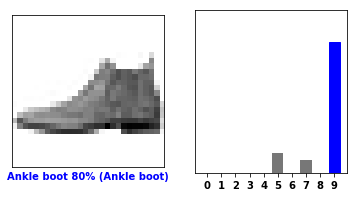

In [114]:
i = 0
plt.figure(figsize=(6 ,3))
plt.subplot(1,2,1)
plot_image(i ,predicitons[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predicitons[i], test_labels)
plt.show()

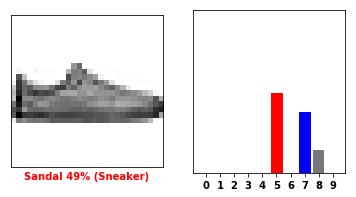

In [115]:
i = 12
plt.figure(figsize=(6 ,3))
plt.subplot(1,2,1)
plot_image(i ,predicitons[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predicitons[i], test_labels)
plt.show()

In [116]:
# plot多张图片

In [117]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.

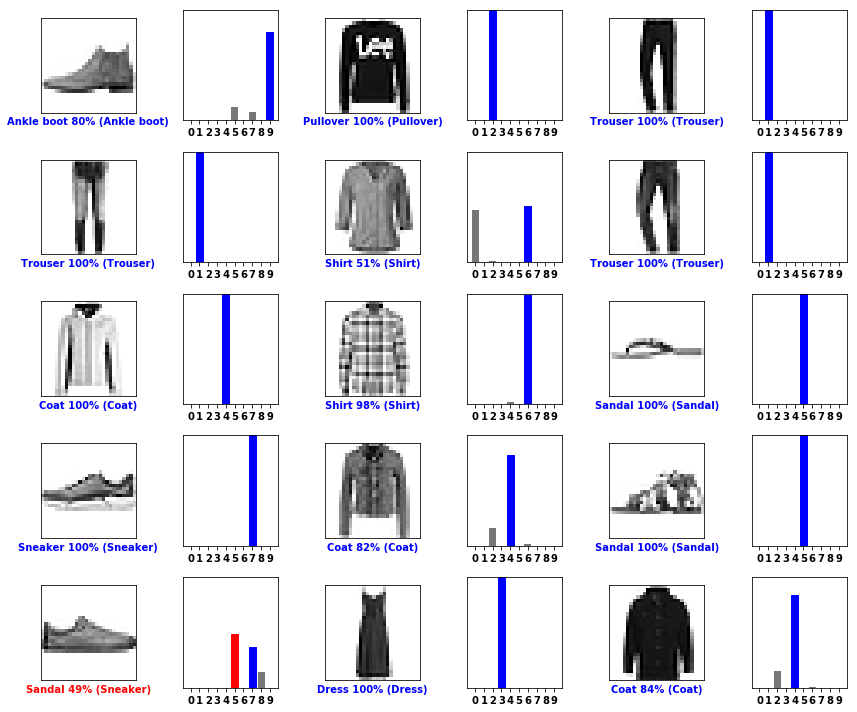

In [119]:
num_rows = 5
num_cols = 3
num_images = num_rows * num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2 * num_cols, 2*i + 1)
    plot_image(i, predicitons[i], test_labels, test_images)
    plt.subplot(num_rows, 2 * num_cols, 2*i + 2)
    plot_value_array(i, predicitons[i], test_labels)
plt.tight_layout()
plt.show()

#### Use the trained model

In [121]:
# 用已经训练好的模型对单个图片进行预测

In [122]:
img = test_images[1]
print(img.shape)

(28, 28)


tf.keras models are optimized to make predictions on a batch, or collection, of examples at once. Accordingly, even though you're using a single image

In [123]:
# Add the image to a batch where it's the only member.
img = (np.expand_dims(img, 0))
print(img.shape)

(1, 28, 28)


In [125]:
predicitons_single = probability_model.predict(img)
print(predicitons_single)

[[4.6013656e-06 8.9204408e-17 9.9963713e-01 3.4472932e-13 3.1328952e-04
  4.3999977e-17 4.4929689e-05 8.5061373e-16 3.5990369e-14 5.8409613e-16]]


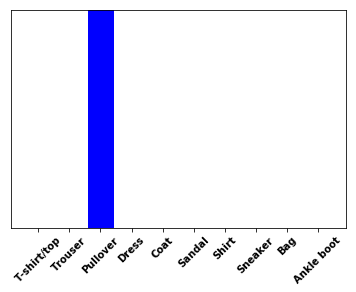

In [127]:
plot_value_array(1, predicitons_single[0], test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)

keras.Model.predict returns a list of lists—one list for each image in the batch of data. Grab the predictions for our (only) image in the batch:

In [128]:
np.argmax(predicitons_single[0])

2

### 使用TF Hub进行文本分类

In [130]:
# tf.keras 用于构建和训练模型的高级API
# Tensorflow hub 用于迁移学习的库

使用 Keras 和 Tensorflow Hub 对电影评论进行文本分类

In [136]:
!pip install tensorflow_hub -i https://mirrors.aliyun.com/pypi/simple/ --trusted-host mirrors.aliyun.com

Looking in indexes: https://mirrors.aliyun.com/pypi/simple/


In [137]:
!pip install tensorflow_datasets -i https://mirrors.aliyun.com/pypi/simple/ --trusted-host mirrors.aliyun.com

Looking in indexes: https://mirrors.aliyun.com/pypi/simple/
  Created wheel for dill: filename=dill-0.3.1.1-py3-none-any.whl size=78598 sha256=f38f09a6f0f62104cb0015d6f953500e48b9aebf8f1459aaf568a12ca7ba43c4
  Stored in directory: c:\users\huangm\appdata\local\pip\cache\wheels\c7\48\83\b86babe2500d1fb31415af05737ada858946a6ba854ba58422
  Created wheel for promise: filename=promise-2.3-py3-none-any.whl size=21500 sha256=a5ca32b7cf43e57472985066db6d08fa4b800dd4f6b41c4e3d448fd20a566fff
  Stored in directory: c:\users\huangm\appdata\local\pip\cache\wheels\64\98\76\73cf1a99a8cef27fd68d1993f938de11cafdcbfe7c19eea123
Successfully built dill promise


In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import tensorflow as tf

import tensorflow_hub as hub
import tensorflow_datasets as tfds

print("Version:", tf.__version__)
print("Eager mode:", tf.executing_eagerly())
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else " NOT AVAILABLE")

Version: 2.1.0
Eager mode: True
Hub version: 0.8.0
GPU is  NOT AVAILABLE


#### 下载IMDB数据集

In [2]:
# 将训练集按照 6:4 的比例进行切割，从而最终我们将得到 15,000
# 个训练样本, 10,000 个验证样本以及 25,000 个测试样本

# datasets split方法
# https://github.com/tensorflow/datasets/blob/master/docs/splits.md

# train_validation_split = tfds.Split.TRAIN.subsplit([6,4]) 
# 报错 AttributeError: 'Split' object has no attribute 'subsplit'
# 解决(换一种方法)：https://blog.csdn.net/kiva12138/article/details/104375000?utm_medium=distribute.pc_relevant.none-task-blog-BlogCommendFromMachineLearnPai2-3.nonecase&depth_1-utm_source=distribute.pc_relevant.none-task-blog-BlogCommendFromMachineLearnPai2-3.nonecase

(train_data, validation_data, test_data) = tfds.load(
    name="imdb_reviews",
    split=("train[:30%]", "train[30%:50%]", "test"),
    as_supervised=True
)

#### 探索数据

In [3]:
# 二分类 标签只有0或者1

train_examples_batch, train_labels_batch = next(iter(train_data.batch(10)))
train_examples_batch

<tf.Tensor: shape=(10,), dtype=string, numpy=
array([b'This is a big step down after the surprisingly enjoyable original. This sequel isn\'t nearly as fun as part one, and it instead spends too much time on plot development. Tim Thomerson is still the best thing about this series, but his wisecracking is toned down in this entry. The performances are all adequate, but this time the script lets us down. The action is merely routine and the plot is only mildly interesting, so I need lots of silly laughs in order to stay entertained during a "Trancers" movie. Unfortunately, the laughs are few and far between, and so, this film is watchable at best.',
       b"Perhaps because I was so young, innocent and BRAINWASHED when I saw it, this movie was the cause of many sleepless nights for me. I haven't seen it since I was in seventh grade at a Presbyterian school, so I am not sure what effect it would have on me now. However, I will say that it left an impression on me... and most of my friends

In [4]:
train_labels_batch

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 1, 0, 1, 0, 1, 1, 1, 0], dtype=int64)>

#### 构建模型

神经网络搭建:
+ 如何表示文本(embedding)
+ 模型多少层(layers)
+ 每层的隐藏单元数(hidden units)

这里使用预先训练好的文本嵌入作为首层    
使用 TensorFlow Hub 中名为 google/tf2-preview/gnews-swivel-20dim/1 的一种预训练文本嵌入（text embedding）模型 。

为了达到本教程的目的还有其他三种预训练模型可供测试：

+ google/tf2-preview/gnews-swivel-20dim-with-oov/1 ——类似 google/tf2-preview/gnews-swivel-20dim/1，但 2.5%的词汇转换为未登录词桶（OOV buckets）。如果任务的词汇与模型的词汇没有完全重叠，这将会有所帮助。
+ google/tf2-preview/nnlm-en-dim50/1 ——一个拥有约 1M 词汇量且维度为 50 的更大的模型。
+ google/tf2-preview/nnlm-en-dim128/1 ——拥有约 1M 词汇量且维度为128的更大的模型。

In [5]:
# 嵌入形状 (num_examples, embedding_dimension)

In [6]:
hub.__version__

'0.8.0'

In [ ]:
embedding = "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1"

hub_layer = hub.KerasLayer(embedding, input_shape=[],output=[20],
                          dtype=tf.string, trainable=True)
hub_layer(train_examples_batch[:3])

In [8]:
# 网络问题，连接失败

In [ ]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation="relu"))
mode.add(tf.keras.layers.Dense(1, activation="sigmoid"))

model.summary()

层按顺序堆叠以构建分类器：

+ 第一层是 Tensorflow Hub 层。这一层使用一个预训练的保存好的模型来将句子映射为嵌入向量（embedding vector）。我们所使用的预训练文本嵌入（embedding）模型(google/tf2-preview/gnews-swivel-20dim/1)将句子切割为符号，嵌入（embed）每个符号然后进行合并。最终得到的维度是：(num_examples, embedding_dimension)。
+ 该定长输出向量通过一个有 16 个隐层单元的全连接层（Dense）进行管道传输。
+ 最后一层与单个输出结点紧密相连。使用 Sigmoid 激活函数，其函数值为介于 0 与 1 之间的浮点数，表示概率或置信水平。

#### 损失函数与优化器

一个模型需要损失函数和优化器来进行训练。由于这是一个二分类问题且模型输出概率值（一个使用 sigmoid 激活函数的单一单元层），我们将使用 binary_crossentropy 损失函数。

这不是损失函数的唯一选择，例如，您可以选择 mean_squared_error 。但是，一般来说 binary_crossentropy 更适合处理概率——它能够度量概率分布之间的“距离”，或者在我们的示例中，指的是度量 ground-truth 分布与预测值之间的“距离”。

In [ ]:
model.compile(optimizer="adam",
             loss="binary_crossentropy",
             metrics=["accuracy"])

#### 训练模型

以 512 个样本的 mini-batch 大小迭代 20 个 epoch 来训练模型。 这是指对 x_train 和 y_train 张量中所有样本的的 20 次迭代。在训练过程中，监测来自验证集的 10,000 个样本上的损失值（loss）和准确率（accuracy）：

In [ ]:
history = model.fit(train_data.shuffle(10000).batch(512),
                   epochs=20,
                   validation_data=validation_data.batch(512),
                   verbose=1)

#### 评估模型

将返回两个值。损失值（loss）（一个表示误差的数字，值越低越好）与准确率（accuracy）。

In [ ]:
results = model.evaluate(test_data.batch(512),verbose=2)
for name, value in zip(model.metrics_names, result):
    print("%s: %.3f" % (name, value))

### 对预处理文本进行文本分类

电影评论分类

In [9]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
from tensorflow import keras

import numpy as np

print(tf.__version__)

2.1.0


#### 下载IMDB数据集

In [10]:
imdb = keras.datasets.imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

17465344/17464789 [==============================] - ETA: 10:2 - ETA: 4:2 - ETA: 4: - ETA: 3: - ETA: 3: - ETA: 2: - ETA: 2: - ETA: 3: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA:

参数 num_words=10000 保留了训练数据中最常出现的 10,000 个单词。为了保持数据规模的可管理性，低频词将被丢弃。

#### 探索数据

In [11]:
print("Training entries:{}, labels:{}".format(len(train_data), len(train_labels)))

Training entries:25000, labels:25000


In [12]:
# 评论文本被转化为整数值，每个整数代表词典中的一个单词
print(train_data[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


In [13]:
# 电影评论可能出现不同的长度，而神经网路的输入必须是统一的长度u，后续需要解决
len(train_data[0]), len(train_data[1])

(218, 189)

#### 将整数转换为单词

In [14]:
# 一个映射单词到整数索引的词典
word_index = imdb.get_word_index()

# 保留第一个索引
word_index = {k:(v+3) for k, v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2 # unknown
word_index["<UNUSED>"] = 3

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return " ".join([reverse_word_index.get(i, "?") for i in text])

1646592/1641221 [==============================] - ETA: 36 - ETA: 41 - ETA: 13 - ETA: 11 - ETA: 8 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 7s 4us/step


In [15]:
decode_review(train_data[0])

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

#### 准备数据

影评——即整数数组必须在输入神经网络之前转换为张量。这种转换可以通过以下两种方式来完成：

+ 将数组转换为表示单词出现与否的由 0 和 1 组成的向量，类似于 one-hot 编码。例如，序列[3, 5]将转换为一个 10,000 维的向量，该向量除了索引为 3 和 5 的位置是 1 以外，其他都为 0。然后，将其作为网络的首层——一个可以处理浮点型向量数据的稠密层。不过，这种方法需要大量的内存，需要一个大小为 num_words * num_reviews 的矩阵。

+ 或者，我们可以填充数组来保证输入数据具有相同的长度，然后创建一个大小为 max_length * num_reviews 的整型张量。我们可以使用能够处理此形状数据的嵌入层作为网络中的第一层。

In [16]:
# 采用第二种方法

#使用pad_sequence函数来使长度标准化

In [19]:
train_data  = keras.preprocessing.sequence.pad_sequences(train_data,
                                                        value=word_index["<PAD>"],
                                                        padding="post",
                                                        maxlen=256)

test_data = keras.preprocessing.sequence.pad_sequences(test_data,
                                                      value=word_index["<PAD>"],
                                                      padding="post",
                                                      maxlen=256)

In [20]:
len(train_data[0]), len(train_data[1])

(256, 256)

In [22]:
print(train_data[0])

[   1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941
    4  173   36  256    5   25  100   43  838  112   50  670    2    9
   35  480  284    5  150    4  172  112  167    2  336  385   39    4
  172 4536 1111   17  546   38   13  447    4  192   50   16    6  147
 2025   19   14   22    4 1920 4613  469    4   22   71   87   12   16
   43  530   38   76   15   13 1247    4   22   17  515   17   12   16
  626   18    2    5   62  386   12    8  316    8  106    5    4 2223
 5244   16  480   66 3785   33    4  130   12   16   38  619    5   25
  124   51   36  135   48   25 1415   33    6   22   12  215   28   77
   52    5   14  407   16   82    2    8    4  107  117 5952   15  256
    4    2    7 3766    5  723   36   71   43  530  476   26  400  317
   46    7    4    2 1029   13  104   88    4  381   15  297   98   32
 2071   56   26  141    6  194 7486   18    4  226   22   21  134  476
   26  480    5  144   30 5535   18   51   36   28  224   92   25  104
    4 

#### 构建模型

神经网络由堆叠的层来构建，这需要从两个主要方面来进行体系结构决策：

+ 模型里有多少层？
+ 每个层里有多少隐层单元（hidden units）？

In [24]:
# keras Embedding： https://blog.csdn.net/songbinxu/article/details/80150019
# GlobalAveragePooling1D： https://blog.csdn.net/weixin_43824178/article/details/99182766

In [25]:
# 输入形状是用于电影评论的词汇数目(10000词)
vocab_size = 10000

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 16))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(16, activation="relu"))
model.add(keras.layers.Dense(1, activation="sigmoid"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


层按顺序堆叠以构建分类器：

+ 第一层是嵌入（Embedding）层。该层采用整数编码的词汇表，并查找每个词索引的嵌入向量（embedding vector）。这些向量是通过模型训练学习到的。向量向输出数组增加了一个维度。得到的维度为：(batch, sequence, embedding)。
+ 接下来，GlobalAveragePooling1D 将通过对序列维度求平均值来为每个样本返回一个定长输出向量。这允许模型以尽可能最简单的方式处理变长输入。
+ 该定长输出向量通过一个有 16 个隐层单元的全连接（Dense）层传输。
+ 最后一层与单个输出结点密集连接。使用 Sigmoid 激活函数，其函数值为介于 0 与 1 之间的浮点数，表示概率或置信度。

#### 损失函数和优化器

In [26]:
model.compile(optimizer="adam",
             loss="binary_crossentropy",
             metrics=["accuracy"])

#### 创建验证集

In [28]:
x_val = train_data[:10000]
partial_x_train = train_data[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

#### 训练模型

In [29]:
history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs=40,
                   batch_size=512,
                   validation_data=(x_val, y_val),
                   verbose=1)

Train on 15000 samples, validate on 10000 samples
Epoch 1/40
15000/15000 [==============================] - ETA: 33s - loss: 0.6936 - accuracy: 0.492 - ETA: 17s - loss: 0.6933 - accuracy: 0.510 - ETA: 8s - loss: 0.6931 - accuracy: 0.527 - ETA: 4s - loss: 0.6929 - accuracy: 0.53 - ETA: 2s - loss: 0.6927 - accuracy: 0.54 - ETA: 1s - loss: 0.6926 - accuracy: 0.53 - ETA: 1s - loss: 0.6925 - accuracy: 0.52 - ETA: 0s - loss: 0.6923 - accuracy: 0.54 - ETA: 0s - loss: 0.6922 - accuracy: 0.57 - ETA: 0s - loss: 0.6920 - accuracy: 0.58 - ETA: 0s - loss: 0.6918 - accuracy: 0.60 - 2s 130us/sample - loss: 0.6917 - accuracy: 0.6102 - val_loss: 0.6897 - val_accuracy: 0.7352
Epoch 2/40
15000/15000 [==============================] - ETA: 0s - loss: 0.6895 - accuracy: 0.74 - ETA: 0s - loss: 0.6891 - accuracy: 0.74 - ETA: 0s - loss: 0.6888 - accuracy: 0.74 - ETA: 0s - loss: 0.6885 - accuracy: 0.73 - ETA: 0s - loss: 0.6883 - accuracy: 0.72 - ETA: 0s - loss: 0.6880 - accuracy: 0.71 - ETA: 0s - loss: 0.6876 

Epoch 15/40
15000/15000 [==============================] - ETA: 0s - loss: 0.2840 - accuracy: 0.92 - ETA: 0s - loss: 0.2826 - accuracy: 0.90 - ETA: 0s - loss: 0.2772 - accuracy: 0.90 - ETA: 0s - loss: 0.2793 - accuracy: 0.90 - ETA: 0s - loss: 0.2766 - accuracy: 0.90 - ETA: 0s - loss: 0.2766 - accuracy: 0.90 - ETA: 0s - loss: 0.2775 - accuracy: 0.90 - ETA: 0s - loss: 0.2777 - accuracy: 0.90 - ETA: 0s - loss: 0.2777 - accuracy: 0.90 - ETA: 0s - loss: 0.2768 - accuracy: 0.90 - 1s 50us/sample - loss: 0.2757 - accuracy: 0.9059 - val_loss: 0.3262 - val_accuracy: 0.8738
Epoch 16/40
15000/15000 [==============================] - ETA: 0s - loss: 0.2617 - accuracy: 0.90 - ETA: 0s - loss: 0.2652 - accuracy: 0.90 - ETA: 0s - loss: 0.2684 - accuracy: 0.90 - ETA: 0s - loss: 0.2689 - accuracy: 0.90 - ETA: 0s - loss: 0.2704 - accuracy: 0.90 - ETA: 0s - loss: 0.2687 - accuracy: 0.90 - ETA: 0s - loss: 0.2664 - accuracy: 0.90 - ETA: 0s - loss: 0.2649 - accuracy: 0.90 - ETA: 0s - loss: 0.2635 - accuracy: 

15000/15000 [==============================] - ETA: 0s - loss: 0.1888 - accuracy: 0.92 - ETA: 0s - loss: 0.1549 - accuracy: 0.94 - ETA: 0s - loss: 0.1496 - accuracy: 0.95 - ETA: 0s - loss: 0.1486 - accuracy: 0.95 - ETA: 0s - loss: 0.1455 - accuracy: 0.95 - ETA: 0s - loss: 0.1446 - accuracy: 0.95 - ETA: 0s - loss: 0.1442 - accuracy: 0.95 - ETA: 0s - loss: 0.1446 - accuracy: 0.95 - ETA: 0s - loss: 0.1445 - accuracy: 0.95 - ETA: 0s - loss: 0.1447 - accuracy: 0.95 - 1s 42us/sample - loss: 0.1442 - accuracy: 0.9561 - val_loss: 0.2869 - val_accuracy: 0.8868
Epoch 30/40
15000/15000 [==============================] - ETA: 0s - loss: 0.1532 - accuracy: 0.94 - ETA: 0s - loss: 0.1333 - accuracy: 0.95 - ETA: 0s - loss: 0.1351 - accuracy: 0.95 - ETA: 0s - loss: 0.1352 - accuracy: 0.95 - ETA: 0s - loss: 0.1356 - accuracy: 0.95 - ETA: 0s - loss: 0.1368 - accuracy: 0.95 - ETA: 0s - loss: 0.1384 - accuracy: 0.95 - ETA: 0s - loss: 0.1382 - accuracy: 0.95 - ETA: 0s - loss: 0.1373 - accuracy: 0.95 - ETA: 

#### 评估模型

In [31]:
# 评估模型的性能，返回两个值分别为loss和accuracy
results = model.evaluate(test_data, test_labels, verbose=2)
print(results)

25000/25000 - 1s - loss: 0.3315 - accuracy: 0.8723
[0.33147322151184083, 0.87228]


#### 创建一个准确率和损失值随时间变化的图表

model.fit() 返回一个 History 对象，该对象包含一个字典，其中包含训练阶段所发生的一切事件：

In [32]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

有四个条目：在训练和验证期间，每个条目对应一个监控指标。我们可以使用这些条目来绘制训练与验证过程的损失值（loss）和准确率（accuracy），以便进行比较。

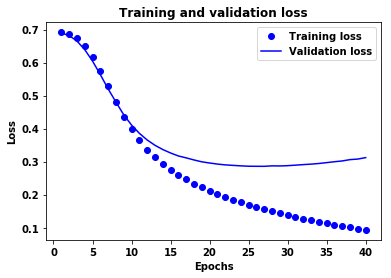

In [34]:
import matplotlib.pyplot as plt

acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]

epochs = range(1, len(acc) + 1)

# "bo"代表 “蓝点”
plt.plot(epochs, loss, "bo", label="Training loss")
# b代表 “蓝色实线”
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

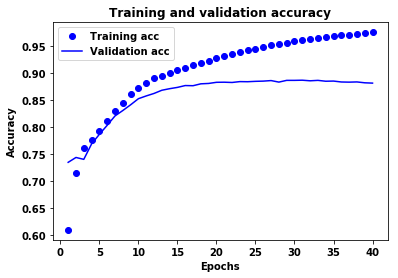

In [35]:
plt.clf() # 清除数字

plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

### 回归

In [36]:
# 使用 seaborn 绘制矩阵图(pariplot)
!pip install -q seaborn

In [40]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.1.0


Auto MPG数据集

#### 获取数据

In [41]:
# 下载数据
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

32768/30286 [================================] ETA:  - ETA:  - ETA:  - 5s 144us/step


'C:\\Users\\huangm\\.keras\\datasets\\auto-mpg.data'

In [43]:
# 使用pandas导入数据集
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                         na_values="?", comment="\t",
                         sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


#### 数据清洗

In [47]:
# 查看NA值
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [48]:
# 删除NA值所在的行
dataset = dataset.dropna()

"Origin" 列实际上代表分类，而不仅仅是一个数字。所以把它转换为独热码 （one-hot）:

In [50]:
origin = dataset.pop("Origin")

In [56]:
# 查看种类
origin.value_counts()

1    245
3     79
2     68
Name: Origin, dtype: int64

In [51]:
dataset["USA"] = (origin == 1) * 1.0
dataset["Europe"] = (origin == 2) * 1.0
dataset["Japan"] = (origin == 3) * 1.0
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


#### 拆分训练数据集和测试数据集

In [59]:
dataset.index

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            388, 389, 390, 391, 392, 393, 394, 395, 396, 397],
           dtype='int64', length=392)

In [60]:
# 拆分数据集，使用测试数据集对模型进行评估

train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

数据检查

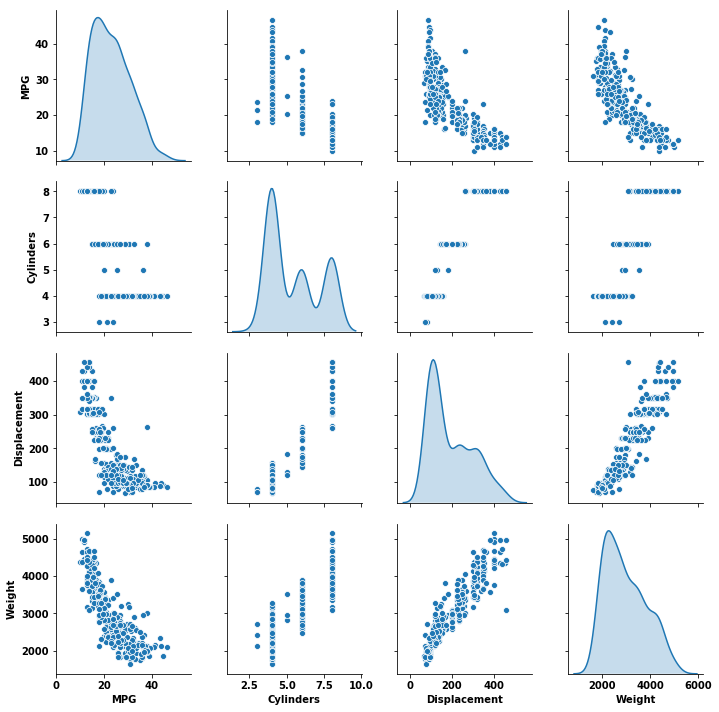

In [61]:
# 快速查看训练集中几对列的联合分布

sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

In [64]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


从标签中分离特征

In [65]:
# 将特征值从目标值或者"标签"中分离。 这个标签是你使用训练模型进行预测的值。

train_labels = train_dataset.pop("MPG")
test_labels = test_dataset.pop("MPG")

数据规范化

使用不同的尺度和范围对特征归一化是好的实践。尽管模型可能 在没有特征归一化的情况下收敛，它会使得模型训练更加复杂，并会造成生成的模型依赖输入所使用的单位选择。

注意：尽管我们仅仅从训练集中有意生成这些统计数据，但是这些统计信息也会用于归一化的测试数据集。我们需要这样做，将测试数据集放入到与已经训练过的模型相同的分布中。

In [67]:
def norm(x):
    """归一化"""
    return (x - train_stats["mean"]) / train_stats["std"]

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [68]:
# 警告: 用于归一化输入的数据统计（均值和标准差）需要反馈给模型从而应用于任何其他数据

In [72]:
train_dataset.keys()

Index(['Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration',
       'Model Year', 'USA', 'Europe', 'Japan'],
      dtype='object')

#### 构建模型

构建模型 ：    
我们将会使用一个“顺序”模型，其中包含两个紧密相连的隐藏层，以及返回单个、连续值得输出层

In [74]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation="relu", input_shape=[len(train_dataset.keys())]),
        layers.Dense(64, activation="relu"),
        layers.Dense(1)
    ])
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    
    model.compile(loss="mse",
                 optimizer=optimizer,
                 metrics=["mae", "mse"])
    return model

In [75]:
model = build_model()

检查模型：

In [76]:
# 使用.summay方法打印该模型的简单描述
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 64)                640       
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [77]:
# 使用
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[ 0.2267621 ],
       [ 0.1510026 ],
       [-0.02871213],
       [ 0.36990958],
       [ 0.82545185],
       [ 0.01788014],
       [ 0.85847306],
       [-0.00670937],
       [ 0.06877758],
       [ 0.5030005 ]], dtype=float32)

#### 训练模型

In [78]:
# 对模型进行1000个周期的训练，并在 history 对象中记录训练和验证的准确性。

In [79]:
# 通过为每个完成的时期打印一个点来显示训练进度
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print("")
        print(".", end="")
        
EPOCHS = 1000

history = model.fit(
    normed_train_data, train_labels,
    epochs=EPOCHS, validation_split=0.2, verbose=0,
    callbacks=[PrintDot()]
)


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

使用 history 对象中存储的统计信息可视化模型的训练进度。

In [81]:
history.history.keys()

dict_keys(['loss', 'mae', 'mse', 'val_loss', 'val_mae', 'val_mse'])

In [83]:
# history.epoch

In [84]:
hist = pd.DataFrame(history.history)
hist["epoch"] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,2.087536,0.866963,2.087536,9.293577,2.278764,9.293577,995
996,1.979845,0.859931,1.979845,8.663844,2.268161,8.663843,996
997,2.185035,0.904075,2.185035,9.008751,2.325166,9.008751,997
998,2.424686,0.966130,2.424686,8.956639,2.227407,8.956640,998
999,2.215607,0.915260,2.215607,9.401766,2.237398,9.401767,999


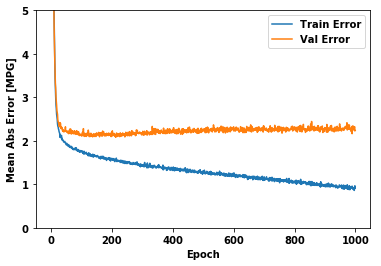

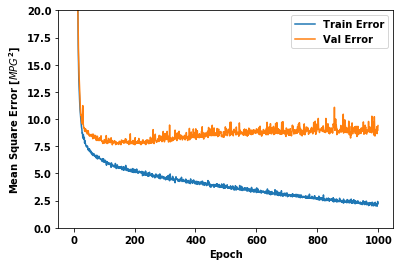

In [85]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist["epoch"] = history.epoch
    
    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Mean Abs Error [MPG]")
    plt.plot(hist["epoch"], hist["mae"],label="Train Error")
    plt.plot(hist["epoch"], hist["val_mae"], label="Val Error")
    
    plt.ylim([0, 5])
    plt.legend()
    
    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Mean Square Error [$MPG^2$]")
    plt.plot(hist["epoch"], hist["mse"], label="Train Error")
    plt.plot(hist["epoch"], hist["val_mse"], label="Val Error")
    
    plt.ylim([0,20])
    plt.legend()
    plt.show()

plot_history(history)

该图表显示在约100个 epochs 之后误差非但没有改进，反而出现恶化。 让我们更新 model.fit 调用，当验证值没有提高上是自动停止训练。 我们将使用一个 EarlyStopping callback 来测试每个 epoch 的训练条件。如果经过一定数量的 epochs 后没有改进，则自动停止训练。


............................................................................

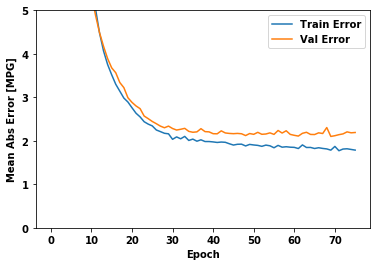

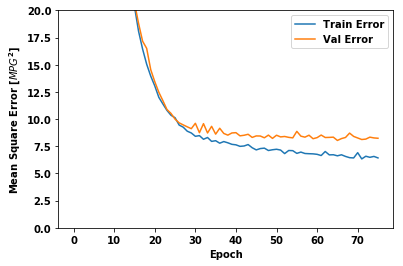

In [86]:
model = build_model()

# patience 值用来检查改进 epochs的数量
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                   validation_split=0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

In [87]:
# 如图所示，验证集中的平均的误差通常在 +/- 2 MPG左右。 这个结果好么？ 我们将决定权留给你。

让我们看看通过使用 测试集 来泛化模型的效果如何，我们在训练模型时没有使用测试集

In [88]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)
print("Testing  set Meas Abs Error: {:5.2f} MPG".format(mae))

78/78 - 0s - loss: 5.6642 - mae: 1.8731 - mse: 5.6642
Testing  set Meas Abs Error:  1.87 MPG


#### 预测

使用测试集的数据预测MPG值

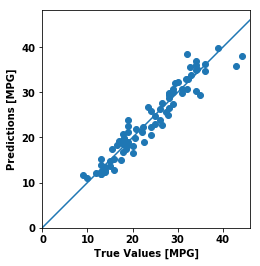

In [90]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel("True Values [MPG]")
plt.ylabel("Predictions [MPG]")
plt.axis("equal")
plt.axis("square")
plt.xlim([0, plt.xlim()[1]])
plt.ylim([0, plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

这看起来我们的模型预测得相当好。我们来看下误差分布。

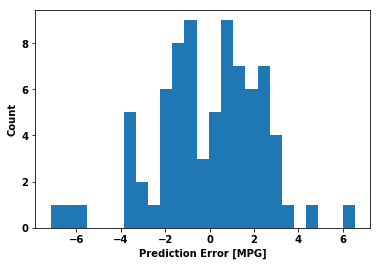

In [91]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

它不是完全的高斯分布，但我们可以推断出，这是因为样本的数量很小所导致的。

#### 结论

In [ ]:
+ 均方误差（MSE）是用于回归问题的常见损失函数（分类问题中使用不同的损失函数）
+ 类似的，用于回归的评估指标与分类不同。 常见的回归指标是平均绝对误差（MAE）
+ 当数字输入数据特征的值存在不同范围时，每个特征应独立缩放到相同范围
+ 如果训练数据不多，一种方法是选择隐藏层较少的小网络，以避免过度拟合
+ 早期停止是一种防止过度拟合的有效技术